In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import lib.dataset as dataset
import lib.params as params
import lib.network as network
import lib.path as path
import lib.utils as utils
from datetime import datetime

In [3]:
# read params
with open("config/train.params") as f:
    learning_rate=float(params.read_param(f.readline()))
    batch_size=int(params.read_param(f.readline()))
    epoch=int(params.read_param(f.readline()))
   
    print("training with a learning rate of {} for {} epochs with batchs of size {}".format(learning_rate,epoch,batch_size))

    
data_all=np.array(sorted(path.construct_path_lists("out","data_")))
label_all=np.array(sorted(path.construct_path_lists("out","labels_")))
# print(data_all.shape,label_all.shape)

print("creating network...")
net=network.R2N2(learning_rate)
print(" ...network created")

training with a learning rate of 0.1 for 1 epochs with batchs of size 3
creating network...
encoder_network
recurrent_module
decoder_network
setup loss function
initializing network
 ...network created


In [4]:
net.restore("/Users/micmelesse/Documents/thesis/aws/model_0.1_5_10 2018-02-11_02:09:41/epoch_000")

INFO:tensorflow:Restoring parameters from /Users/micmelesse/Documents/thesis/aws/model_0.1_5_10 2018-02-11_02:09:41/epoch_000/model.ckpt


(1, 4, 4, 4, 256)
(1, 4, 4, 4, 256)


KeyboardInterrupt: 

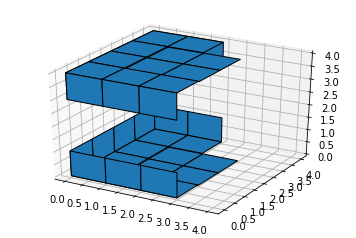

In [5]:
i=0
d=utils.to_npy(data_all[i])
l=utils.to_npy(label_all[i])
prediction=net.save_state("./game",d,l)

In [ ]:
prediction.shape

In [ ]:
model_dir="out/model_{}_{}_{} {}".format(learning_rate,epoch,batch_size,datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
    
# train network
loss_all=[]
acc_all=[]
N=len(data_all)
print("starting training")
for e in range(epoch):
    start_time=time.time()
    perm=np.random.permutation(N)
    data_all=data_all[perm]
    label_all=label_all[perm]
    data_batchs=np.array_split(data_all,math.ceil(N/batch_size))
    label_batchs=np.array_split(label_all,math.ceil(N/batch_size))
    
    loss_epoch=[]
    acc_epoch=[]
    batch_number=0
    for data,label in zip(data_batchs,label_batchs):
        data=utils.to_npy(data)
        label=utils.to_npy(label)
        train_step=net.train_step(data,label)
        loss_epoch.append(net.batch_loss.eval(fd))
        print("epoch_{:03d}-batch_{:03d}: loss={}".format(e,batch_number,loss_epoch[-1]))
        batch_number+=1
    save_dir="{}/epoch_{:03d}".format(model_dir,e)
    loss_all.append(loss_epoch)
    net.save(save_dir,"loss",loss_all)
    print("epoch %d took %d seconds"%(e,time.time()-start_time))